找到 1705 个匹配的文件键。
匹配文件 Key: 100_brightness, LR: image_plot_100_brightness.png, HR: frame_100_brightness.png
匹配文件 Key: 100_contrast, LR: image_plot_100_contrast.png, HR: frame_100_contrast.png
匹配文件 Key: 100_fixed_crop, LR: image_plot_100_fixed_crop.png, HR: frame_100_fixed_crop.png
匹配文件 Key: 100_flip_left_right, LR: image_plot_100_flip_left_right.png, HR: frame_100_flip_left_right.png
匹配文件 Key: 100_flip_top_bottom, LR: image_plot_100_flip_top_bottom.png, HR: frame_100_flip_top_bottom.png
匹配文件 Key: 100_gaussian_blur, LR: image_plot_100_gaussian_blur.png, HR: frame_100_gaussian_blur.png
匹配文件 Key: 100_noise, LR: image_plot_100_noise.png, HR: frame_100_noise.png
匹配文件 Key: 100_rotate_180, LR: image_plot_100_rotate_180.png, HR: frame_100_rotate_180.png
匹配文件 Key: 100_rotate_90, LR: image_plot_100_rotate_90.png, HR: frame_100_rotate_90.png
匹配文件 Key: 100_scale, LR: image_plot_100_scale.png, HR: frame_100_scale.png
匹配文件 Key: 100_translate, LR: image_plot_100_translate.png, HR: frame_100_translate.

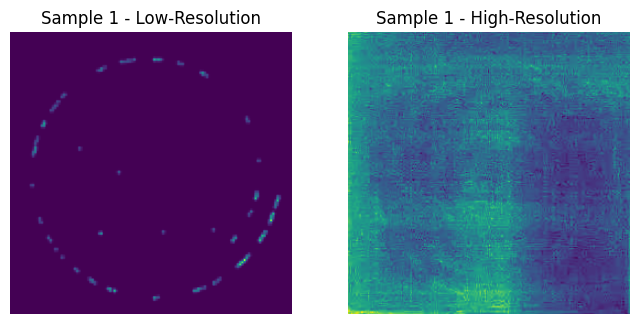

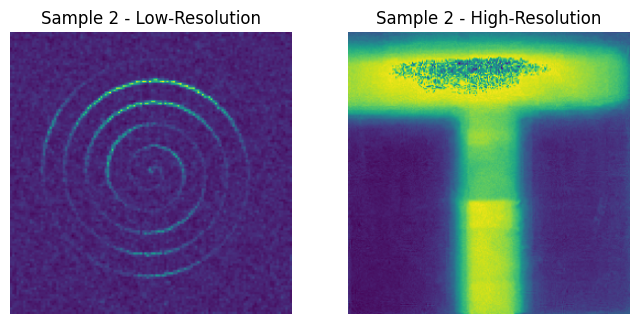

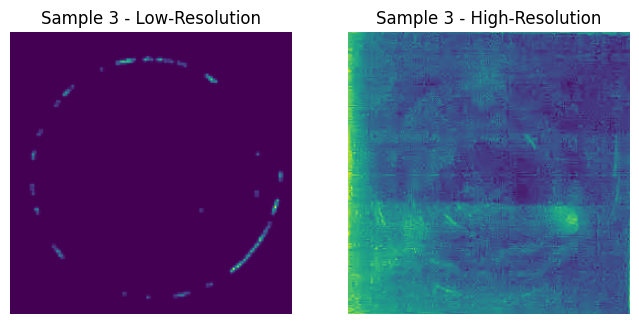

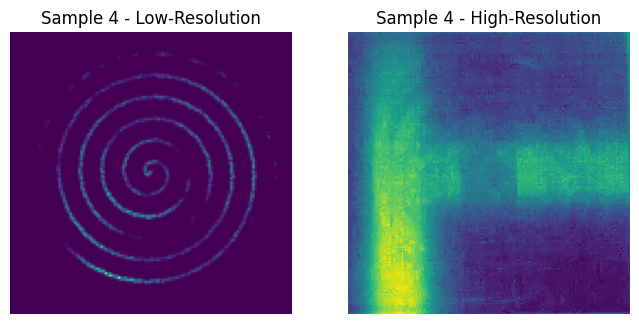

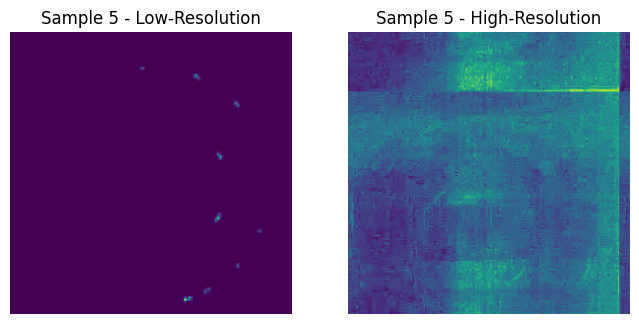

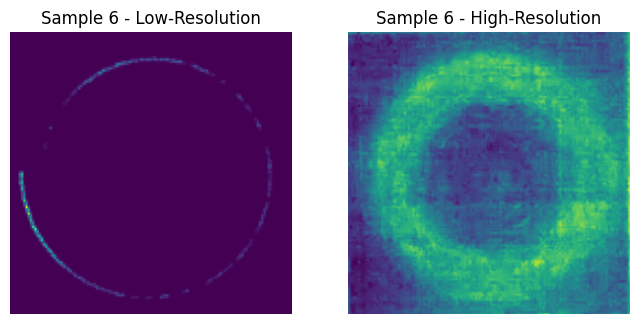

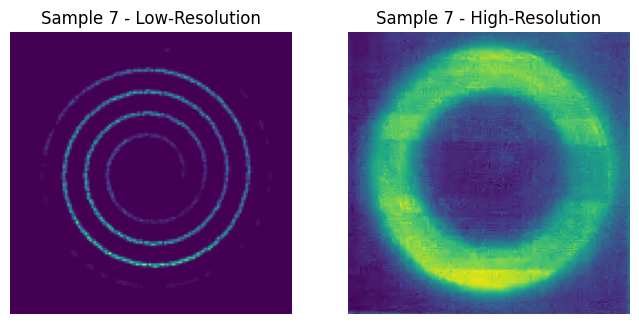

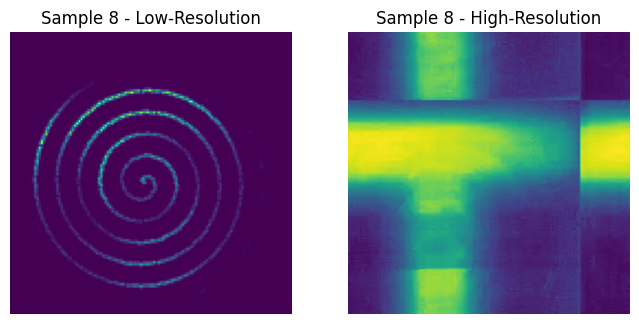

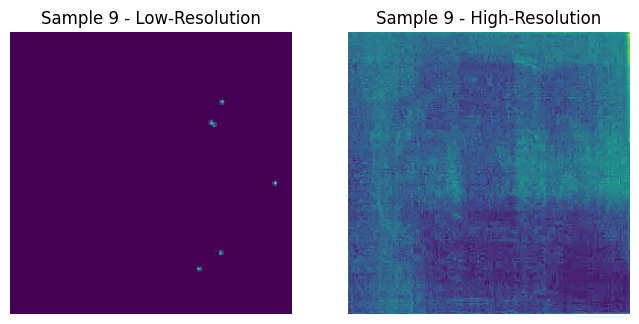

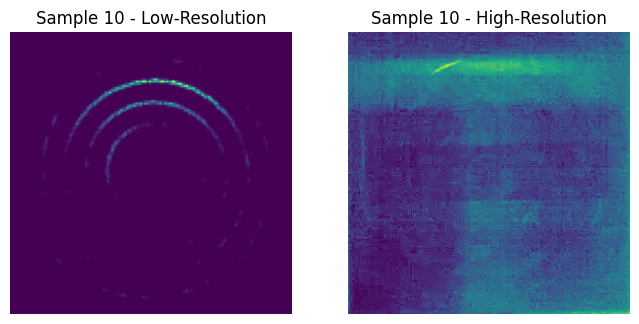

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
from skimage import io
from skimage.transform import resize

class TemperatureDataset(Dataset):
    def __init__(self, lr_image_files, hr_image_files, lr_img_size=128, hr_img_size=256):
        self.lr_image_files = lr_image_files
        self.hr_image_files = hr_image_files
        self.lr_img_size = lr_img_size
        self.hr_img_size = hr_img_size
        self.lr_images = []
        self.hr_images = []
        self.prepare_data()
        
    def prepare_data(self):
        for lr_file, hr_file in zip(self.lr_image_files, self.hr_image_files):
            # 读取图像文件
            lr_image = io.imread(lr_file)
            hr_image = io.imread(hr_file)
            
            # 如果图像是彩色的，转换为灰度图
            if lr_image.ndim == 3:
                lr_image = lr_image.mean(axis=2)  # 简单求平均转换为灰度图
            if hr_image.ndim == 3:
                hr_image = hr_image.mean(axis=2)
            
            # 将 LR 图像下采样至指定大小
            lr_image_resized = resize(lr_image, (self.lr_img_size, self.lr_img_size), mode='reflect', anti_aliasing=True)
            
            # 将 HR 图像下采样至指定大小
            hr_image_resized = resize(hr_image, (self.hr_img_size, self.hr_img_size), mode='reflect', anti_aliasing=True)
            
            # 将图像归一化到 [0, 1]
            lr_image_resized = (lr_image_resized - lr_image_resized.min()) / (lr_image_resized.max() - lr_image_resized.min() + 1e-8)
            hr_image_resized = (hr_image_resized - hr_image_resized.min()) / (hr_image_resized.max() - hr_image_resized.min() + 1e-8)
            
            # 添加到列表
            self.lr_images.append(lr_image_resized)
            self.hr_images.append(hr_image_resized)
        
        # 转换为 NumPy 数组
        self.lr_images = np.array(self.lr_images)
        self.hr_images = np.array(self.hr_images)
        print(f"低分辨率图像的形状: {self.lr_images.shape}")
        print(f"高分辨率图像的形状: {self.hr_images.shape}")
    
    def __len__(self):
        return len(self.lr_images)
    
    def __getitem__(self, idx):
        lr = self.lr_images[idx]
        hr = self.hr_images[idx]
        
        # 转换为 tensor
        lr = torch.tensor(lr, dtype=torch.float32).unsqueeze(0)  # (1, H, W)
        hr = torch.tensor(hr, dtype=torch.float32).unsqueeze(0)
        return lr, hr

import os

# 定义数据路径
lr_folder = r'D:\Program\d2l\battery\sparse_data'   # LR 图像文件夹路径
hr_folder = r'D:\Program\d2l\battery\dense_data'    # HR 图像文件夹路径

# 获取 LR 图像文件列表
lr_files = [f for f in os.listdir(lr_folder) if f.endswith('.png') or f.endswith('.jpg')]

# 获取 HR 图像文件列表
hr_files = [f for f in os.listdir(hr_folder) if f.endswith('.png') or f.endswith('.jpg')]

# 提取文件名中的关键部分，建立映射
def get_key(filename, data_type):
    # 去掉文件扩展名
    filename = os.path.splitext(filename)[0]
    # 根据文件类型处理
    if data_type == 'lr':
        # 假设 LR 文件名格式为：image_plot_<编号>_<增强类型>.png
        parts = filename.split('_')
        if len(parts) >= 3:
            key = '_'.join(parts[2:])  # 提取编号和增强类型，例如 '1_brightness'
        else:
            key = filename
    elif data_type == 'hr':
        # 假设 HR 文件名格式为：frame_<编号>_<增强类型>.png
        parts = filename.split('_')
        if len(parts) >= 2:
            key = '_'.join(parts[1:])  # 提取编号和增强类型，例如 '1_brightness'
        else:
            key = filename
    else:
        key = filename
    return key

# 创建 LR 文件的映射
lr_dict = {}
for f in lr_files:
    key = get_key(f, 'lr')
    lr_dict[key] = os.path.join(lr_folder, f)
    #print(f"LR Key: {key}, File: {f}")

# 创建 HR 文件的映射
hr_dict = {}
for f in hr_files:
    key = get_key(f, 'hr')
    hr_dict[key] = os.path.join(hr_folder, f)
    #print(f"HR Key: {key}, File: {f}")

# 找到 LR 和 HR 数据的共同键
common_keys = set(lr_dict.keys()) & set(hr_dict.keys())
if not common_keys:
    print("没有找到匹配的 LR 和 HR 数据文件，请检查文件名格式。")
else:
    print(f"找到 {len(common_keys)} 个匹配的文件键。")

# 根据共同键创建匹配的文件列表
lr_file_list = []
hr_file_list = []
for key in sorted(common_keys):
    lr_file_list.append(lr_dict[key])
    hr_file_list.append(hr_dict[key])
    print(f"匹配文件 Key: {key}, LR: {os.path.basename(lr_dict[key])}, HR: {os.path.basename(hr_dict[key])}")

# 检查文件数量是否一致
assert len(lr_file_list) == len(hr_file_list), "LR 和 HR 数据文件数量不一致！"

# 设置随机种子
random_seed = 44
np.random.seed(random_seed)

# 获取文件数量
total_samples = len(lr_file_list)

# 创建随机排列的索引
indices = np.random.permutation(total_samples)

# 确定训练、验证和测试集的大小
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

# 根据随机索引划分数据集
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

train_lr_files = [lr_file_list[i] for i in train_indices]
train_hr_files = [hr_file_list[i] for i in train_indices]

val_lr_files = [lr_file_list[i] for i in val_indices]
val_hr_files = [hr_file_list[i] for i in val_indices]

test_lr_files = [lr_file_list[i] for i in test_indices]
test_hr_files = [hr_file_list[i] for i in test_indices]

print(f"训练集数量: {len(train_lr_files)}")
print(f"验证集数量: {len(val_lr_files)}")
print(f"测试集数量: {len(test_lr_files)}")
print("数据集划分完成！")

# 创建数据集
train_dataset = TemperatureDataset(train_lr_files, train_hr_files, lr_img_size=128, hr_img_size=256)
val_dataset = TemperatureDataset(val_lr_files, val_hr_files, lr_img_size=128, hr_img_size=256)
test_dataset = TemperatureDataset(test_lr_files, test_hr_files, lr_img_size=128, hr_img_size=256)
# 打印数据集长度和样本形状
print(f"训练集包含 {len(train_dataset)} 个样本。")
print(f"验证集包含 {len(val_dataset)} 个样本。")
print(f"测试集包含 {len(test_dataset)} 个样本。")

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

print("数据加载器创建完成！")

import matplotlib.pyplot as plt

# 显示 10 组数据的图像
num_samples_to_display = 10

for idx in range(num_samples_to_display):
    lr, hr = train_dataset[idx]
    
    # 转换为 numpy 数组
    lr_np = lr.numpy().squeeze()
    hr_np = hr.numpy().squeeze()
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(lr_np)
    plt.title(f'Sample {idx+1} - Low-Resolution')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(hr_np)
    plt.title(f'Sample {idx+1} - High-Resolution')
    plt.axis('off')
    
    plt.show()

In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader

# 生成器定义
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=9, stride=1, padding=4),     #卷积层，输入通道为1（灰度图像），输出通道为64，卷积核大小为9×9，步幅为1，填充为4（保持图像尺寸不变）。
            nn.PReLU()
        )
        self.residual_blocks = self.make_layer(ResidualBlock, 64, 5)     #创建5个残差块（ResidualBlock），每个块的输出通道为64
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),     #输入和输出通道均为64，卷积核大小为3×3，步幅为1，填充为1。
            nn.BatchNorm2d(64)
        )
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 64*4, kernel_size=3, stride=1, padding=1),    #卷积层，将通道数从64增加到256（64×4）。
            nn.PixelShuffle(2),                                           #像素重排，将256通道的数据重新排列为64通道的高分辨率图像，放大因子为2。
            nn.PReLU(),
        )
        self.block3 = nn.Conv2d(64, 1, kernel_size=9, stride=1, padding=4)        #
    
    def make_layer(self, block, out_channels, blocks):
        layers = []
        for _ in range(blocks):
            layers.append(block(out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out1 = self.block1(x)
        out = self.residual_blocks(out1)
        out = self.block2(out)
        out = torch.add(out1, out)
        out = self.upsample(out)
        out = self.block3(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = torch.add(identity, out)
        return out

# 判别器定义
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
            # 移除了 nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.main(x)
        return out.view(out.size(0), -1)

# 实例化模型并移动到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

print("模型已定义并移动到设备:", device)

# 定义损失函数和优化器
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_content = nn.MSELoss()

generator = Generator().cuda()
discriminator = Discriminator().cuda()

optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)
print("损失函数和优化器已定义。")

模型已定义并移动到设备: cuda
损失函数和优化器已定义。


In [3]:
import torch
import torch.nn as nn
from tqdm import tqdm
from pytorch_msssim import ssim, ms_ssim
import numpy as np

# 在训练开始前
log_file = 'training_log32.txt'
with open(log_file, 'w') as f:
    f.write("Epoch, D_Loss, G_Loss, Val_Loss, PSNR, SSIM\n")

num_epochs = 200
best_val_loss = float('inf')  # 用于保存最佳模型


for epoch in range(1, num_epochs + 1):
    print(f"\n=== Epoch {epoch}/{num_epochs} ===")
    generator.train()
    discriminator.train()
    
    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="训练中", dynamic_ncols=True, position=0, leave=False)
    # 用于计算整个 epoch 的平均损失
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    num_batches = len(train_loader)

    for i, (lr_imgs, hr_imgs) in train_bar:
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        # =======================
        # 训练判别器
        # =======================
        optimizer_D.zero_grad()

        # 生成假图像并分离梯度
        fake_imgs = generator(lr_imgs).detach()


        # 确保 fake_imgs 和 hr_imgs 的尺寸相同
        if fake_imgs.size() != hr_imgs.size():
            hr_imgs_resized = nn.functional.interpolate(hr_imgs, size=fake_imgs.shape[2:], mode='bilinear', align_corners=False)
        else:
            hr_imgs_resized = hr_imgs

        # 创建真实和假标签
        real_labels = torch.ones(hr_imgs_resized.size(0), 1, device=device, dtype=torch.float32)
        fake_labels = torch.zeros(hr_imgs.size(0), 1, device=device, dtype=torch.float32)


        # 判别器对真实图像的预测和损失
        real_preds = discriminator(hr_imgs_resized)
        real_loss = criterion_GAN(real_preds, real_labels)

        # 判别器对假图像的预测和损失
        fake_preds = discriminator(fake_imgs)
        fake_loss = criterion_GAN(fake_preds, fake_labels)

        # 判别器总损失
        d_loss = (real_loss + fake_loss) / 2

        # 反向传播和优化
        d_loss.backward()
        optimizer_D.step()

        # 累加判别器的损失
        epoch_d_loss += d_loss.item()

        # =======================
        # 训练生成器
        # =======================
        optimizer_G.zero_grad()

        # 生成假图像
        fake_imgs = generator(lr_imgs)

        # 判别器对假图像的预测（不计算梯度）
        with torch.no_grad():
            preds_fake = discriminator(fake_imgs)

        # 生成器的GAN损失
        gan_loss = criterion_GAN(preds_fake, real_labels)  # 目标是让判别器认为假图像是真实的

        # 内容损失
        content_loss = criterion_content(fake_imgs, hr_imgs_resized)

        # 生成器总损失
        g_loss = content_loss + 1e-3 * gan_loss

        # 反向传播和优化
        g_loss.backward()
        optimizer_G.step()

        # 解冻判别器参数
        for param in discriminator.parameters():
            param.requires_grad = True

        # 累加生成器的损失
        epoch_g_loss += g_loss.item()

        if i % 10 == 0:
            # 更新进度条
            train_bar.set_postfix({
                "D Loss": f"{d_loss.item():.4f}",
                "G Loss": f"{g_loss.item():.4f}"
            }, refresh=True)


    # 计算整个 epoch 的平均损失
    avg_d_loss = epoch_d_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches

    # =======================
    # 验证阶段
    # =======================
    print("验证阶段...")
    generator.eval()
    val_loss = 0
    total_psnr = 0.0
    total_ssim = 0.0
    total_val_samples = 0  # 修改变量名，更准确地描述其含义

    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            fake_imgs = generator(lr_imgs)

            # 确保 fake_imgs 和 hr_imgs 的尺寸相同
            if fake_imgs.size() != hr_imgs.size():
                hr_imgs_resized = nn.functional.interpolate(hr_imgs, size=fake_imgs.shape[2:], mode='bilinear', align_corners=False)
            else:
                hr_imgs_resized = hr_imgs

            # 计算内容损失，乘以批大小以计算总损失
            loss = criterion_content(fake_imgs, hr_imgs_resized)
            val_loss += loss.item() * lr_imgs.size(0)

            # 计算 PSNR 和 SSIM
            # 将张量转换为 [0, 1] 范围并移动到 CPU
            fake_imgs_cpu = fake_imgs.clamp(0, 1).cpu()
            hr_imgs_cpu = hr_imgs_resized.clamp(0, 1).cpu()

            # 假设图像是 [N, C, H, W]
            # 计算每张图像的 PSNR 和 SSIM，然后取平均
            batch_size = fake_imgs_cpu.size(0)
            for i in range(batch_size):
                fake_img = fake_imgs_cpu[i]
                hr_img = hr_imgs_cpu[i]

                # 计算 PSNR
                mse = torch.mean((fake_img - hr_img) ** 2).item()
                if mse == 0:
                    psnr_val = float('inf')
                else:
                    psnr_val = 20 * np.log10(1.0 / np.sqrt(mse))

                # 计算 SSIM
                ssim_val = ssim(fake_img.unsqueeze(0), hr_img.unsqueeze(0), data_range=1.0, size_average=True).item()

                total_psnr += psnr_val
                total_ssim += ssim_val

            total_val_samples += batch_size

    # 计算平均验证损失
    val_loss /= total_val_samples
    avg_psnr = total_psnr / total_val_samples
    avg_ssim = total_ssim / total_val_samples
    print(f"验证损失: {val_loss:.4f}, PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}")

    # =======================
    # 保存最优模型
    # =======================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(generator.state_dict(), 'best_generator_srgan128.pth')
        torch.save(discriminator.state_dict(), 'best_discriminator_srgan128.pth')
        print(f"  保存了新的最佳模型（验证损失: {best_val_loss:.4f}）")

    # 每个 epoch 保存模型
    torch.save(generator.state_dict(), f'generator_srgan_epoch{epoch}.pth')
    torch.save(discriminator.state_dict(), f'discriminator_srgan_epoch{epoch}.pth')

    # =======================
    # 记录和保存训练数据
    # =======================
    with open(log_file, 'a') as f:
        f.write(f"{epoch}, {avg_d_loss:.4f}, {avg_g_loss:.4f}, {val_loss:.4f}, {avg_psnr:.2f}, {avg_ssim:.4f}\n")

print("训练完成！")



=== Epoch 1/200 ===


验证阶段...
验证损失: 0.0536, PSNR: 13.25 dB, SSIM: 0.3228
  保存了新的最佳模型（验证损失: 0.0536）

=== Epoch 2/200 ===


验证阶段...
验证损失: 0.0505, PSNR: 13.45 dB, SSIM: 0.3394
  保存了新的最佳模型（验证损失: 0.0505）

=== Epoch 3/200 ===


验证阶段...
验证损失: 0.0504, PSNR: 13.45 dB, SSIM: 0.3485
  保存了新的最佳模型（验证损失: 0.0504）

=== Epoch 4/200 ===


验证阶段...
验证损失: 0.0508, PSNR: 13.52 dB, SSIM: 0.3806

=== Epoch 5/200 ===


验证阶段...
验证损失: 0.0473, PSNR: 13.70 dB, SSIM: 0.3689
  保存了新的最佳模型（验证损失: 0.0473）

=== Epoch 6/200 ===


验证阶段...
验证损失: 0.0463, PSNR: 13.83 dB, SSIM: 0.3837
  保存了新的最佳模型（验证损失: 0.0463）

=== Epoch 7/200 ===


验证阶段...
验证损失: 0.0473, PSNR: 13.75 dB, SSIM: 0.3825

=== Epoch 8/200 ===


验证阶段...
验证损失: 0.0582, PSNR: 12.97 dB, SSIM: 0.3929

=== Epoch 9/200 ===


验证阶段...
验证损失: 0.0445, PSNR: 14.04 dB, SSIM: 0.4140
  保存了新的最佳模型（验证损失: 0.0445）

=== Epoch 10/200 ===


验证阶段...
验证损失: 0.0432, PSNR: 14.14 dB, SSIM: 0.4108
  保存了新的最佳模型（验证损失: 0.0432）

=== Epoch 11/200 ===


验证阶段...
验证损失: 0.0437, PSNR: 14.09 dB, SSIM: 0.3943

=== Epoch 12/200 ===


验证阶段...
验证损失: 0.0457, PSNR: 13.89 dB, SSIM: 0.3859

=== Epoch 13/200 ===


验证阶段...
验证损失: 0.0448, PSNR: 13.94 dB, SSIM: 0.3892

=== Epoch 14/200 ===


验证阶段...
验证损失: 0.0484, PSNR: 13.96 dB, SSIM: 0.4156

=== Epoch 15/200 ===


验证阶段...
验证损失: 0.0612, PSNR: 13.71 dB, SSIM: 0.3915

=== Epoch 16/200 ===


验证阶段...
验证损失: 0.0414, PSNR: 14.35 dB, SSIM: 0.4101
  保存了新的最佳模型（验证损失: 0.0414）

=== Epoch 17/200 ===


验证阶段...
验证损失: 0.0418, PSNR: 14.39 dB, SSIM: 0.4259

=== Epoch 18/200 ===


验证阶段...
验证损失: 0.0395, PSNR: 14.66 dB, SSIM: 0.4300
  保存了新的最佳模型（验证损失: 0.0395）

=== Epoch 19/200 ===


验证阶段...
验证损失: 0.0401, PSNR: 14.54 dB, SSIM: 0.4262

=== Epoch 20/200 ===


验证阶段...
验证损失: 0.0438, PSNR: 14.02 dB, SSIM: 0.3996

=== Epoch 21/200 ===


验证阶段...
验证损失: 0.0471, PSNR: 13.67 dB, SSIM: 0.3900

=== Epoch 22/200 ===


验证阶段...
验证损失: 0.0491, PSNR: 14.18 dB, SSIM: 0.4348

=== Epoch 23/200 ===


验证阶段...
验证损失: 0.0431, PSNR: 14.22 dB, SSIM: 0.4129

=== Epoch 24/200 ===


验证阶段...
验证损失: 0.0464, PSNR: 14.40 dB, SSIM: 0.4491

=== Epoch 25/200 ===


验证阶段...
验证损失: 0.0369, PSNR: 15.05 dB, SSIM: 0.4488
  保存了新的最佳模型（验证损失: 0.0369）

=== Epoch 26/200 ===


验证阶段...
验证损失: 0.0451, PSNR: 14.40 dB, SSIM: 0.4471

=== Epoch 27/200 ===


验证阶段...
验证损失: 0.0731, PSNR: 13.57 dB, SSIM: 0.4446

=== Epoch 28/200 ===


验证阶段...
验证损失: 0.0379, PSNR: 14.75 dB, SSIM: 0.4297

=== Epoch 29/200 ===


验证阶段...
验证损失: 0.0509, PSNR: 14.49 dB, SSIM: 0.4521

=== Epoch 30/200 ===


验证阶段...
验证损失: 0.0403, PSNR: 14.87 dB, SSIM: 0.4538

=== Epoch 31/200 ===


验证阶段...
验证损失: 0.0389, PSNR: 14.59 dB, SSIM: 0.4290

=== Epoch 32/200 ===


验证阶段...
验证损失: 0.0376, PSNR: 14.77 dB, SSIM: 0.4137

=== Epoch 33/200 ===


验证阶段...
验证损失: 0.0404, PSNR: 14.41 dB, SSIM: 0.4295

=== Epoch 34/200 ===


验证阶段...
验证损失: 0.0571, PSNR: 14.53 dB, SSIM: 0.4499

=== Epoch 35/200 ===


验证阶段...
验证损失: 0.0461, PSNR: 13.91 dB, SSIM: 0.4182

=== Epoch 36/200 ===


验证阶段...
验证损失: 0.0374, PSNR: 15.20 dB, SSIM: 0.4674

=== Epoch 37/200 ===


验证阶段...
验证损失: 0.0419, PSNR: 14.57 dB, SSIM: 0.4611

=== Epoch 38/200 ===


验证阶段...
验证损失: 0.0374, PSNR: 14.75 dB, SSIM: 0.4260

=== Epoch 39/200 ===


验证阶段...
验证损失: 0.0385, PSNR: 14.74 dB, SSIM: 0.4422

=== Epoch 40/200 ===


验证阶段...
验证损失: 0.0384, PSNR: 14.67 dB, SSIM: 0.4341

=== Epoch 41/200 ===


验证阶段...
验证损失: 0.0337, PSNR: 15.30 dB, SSIM: 0.4513
  保存了新的最佳模型（验证损失: 0.0337）

=== Epoch 42/200 ===


验证阶段...
验证损失: 0.0325, PSNR: 15.69 dB, SSIM: 0.4710
  保存了新的最佳模型（验证损失: 0.0325）

=== Epoch 43/200 ===


验证阶段...
验证损失: 0.0332, PSNR: 15.51 dB, SSIM: 0.4726

=== Epoch 44/200 ===


验证阶段...
验证损失: 0.0362, PSNR: 15.20 dB, SSIM: 0.4702

=== Epoch 45/200 ===


验证阶段...
验证损失: 0.0415, PSNR: 14.47 dB, SSIM: 0.4351

=== Epoch 46/200 ===


验证阶段...
验证损失: 0.0335, PSNR: 15.40 dB, SSIM: 0.4608

=== Epoch 47/200 ===


验证阶段...
验证损失: 0.0428, PSNR: 14.18 dB, SSIM: 0.4318

=== Epoch 48/200 ===


验证阶段...
验证损失: 0.0333, PSNR: 15.32 dB, SSIM: 0.4561

=== Epoch 49/200 ===


验证阶段...
验证损失: 0.0494, PSNR: 13.96 dB, SSIM: 0.4314

=== Epoch 50/200 ===


验证阶段...
验证损失: 0.0358, PSNR: 14.94 dB, SSIM: 0.4469

=== Epoch 51/200 ===


验证阶段...
验证损失: 0.0512, PSNR: 13.95 dB, SSIM: 0.4107

=== Epoch 52/200 ===


验证阶段...
验证损失: 0.0335, PSNR: 15.34 dB, SSIM: 0.4610

=== Epoch 53/200 ===


验证阶段...
验证损失: 0.0334, PSNR: 15.27 dB, SSIM: 0.4627

=== Epoch 54/200 ===


验证阶段...
验证损失: 0.0743, PSNR: 12.05 dB, SSIM: 0.3889

=== Epoch 55/200 ===


验证阶段...
验证损失: 0.0405, PSNR: 14.39 dB, SSIM: 0.4333

=== Epoch 56/200 ===


验证阶段...
验证损失: 0.0360, PSNR: 15.50 dB, SSIM: 0.4653

=== Epoch 57/200 ===


验证阶段...
验证损失: 0.0380, PSNR: 15.37 dB, SSIM: 0.4731

=== Epoch 58/200 ===


验证阶段...
验证损失: 0.0362, PSNR: 14.88 dB, SSIM: 0.4410

=== Epoch 59/200 ===


验证阶段...
验证损失: 0.0467, PSNR: 14.50 dB, SSIM: 0.4640

=== Epoch 60/200 ===


验证阶段...
验证损失: 0.0538, PSNR: 14.77 dB, SSIM: 0.4686

=== Epoch 61/200 ===


验证阶段...
验证损失: 0.0352, PSNR: 15.43 dB, SSIM: 0.4721

=== Epoch 62/200 ===


验证阶段...
验证损失: 0.0321, PSNR: 15.63 dB, SSIM: 0.4718
  保存了新的最佳模型（验证损失: 0.0321）

=== Epoch 63/200 ===


验证阶段...
验证损失: 0.0330, PSNR: 15.48 dB, SSIM: 0.4643

=== Epoch 64/200 ===


验证阶段...
验证损失: 0.0589, PSNR: 12.79 dB, SSIM: 0.4029

=== Epoch 65/200 ===


验证阶段...
验证损失: 0.0437, PSNR: 14.10 dB, SSIM: 0.4158

=== Epoch 66/200 ===


验证阶段...
验证损失: 0.0736, PSNR: 11.85 dB, SSIM: 0.3856

=== Epoch 67/200 ===


验证阶段...
验证损失: 0.0325, PSNR: 15.43 dB, SSIM: 0.4639

=== Epoch 68/200 ===


验证阶段...
验证损失: 0.0393, PSNR: 14.54 dB, SSIM: 0.4398

=== Epoch 69/200 ===


验证阶段...
验证损失: 0.0344, PSNR: 15.17 dB, SSIM: 0.4397

=== Epoch 70/200 ===


验证阶段...
验证损失: 0.0316, PSNR: 15.60 dB, SSIM: 0.4569
  保存了新的最佳模型（验证损失: 0.0316）

=== Epoch 71/200 ===


验证阶段...
验证损失: 0.0311, PSNR: 15.86 dB, SSIM: 0.4827
  保存了新的最佳模型（验证损失: 0.0311）

=== Epoch 72/200 ===


验证阶段...
验证损失: 0.0389, PSNR: 14.91 dB, SSIM: 0.4598

=== Epoch 73/200 ===


验证阶段...
验证损失: 0.0312, PSNR: 15.95 dB, SSIM: 0.4840

=== Epoch 74/200 ===


验证阶段...
验证损失: 0.0296, PSNR: 16.01 dB, SSIM: 0.4798
  保存了新的最佳模型（验证损失: 0.0296）

=== Epoch 75/200 ===


验证阶段...
验证损失: 0.0331, PSNR: 15.47 dB, SSIM: 0.4568

=== Epoch 76/200 ===


验证阶段...
验证损失: 0.0368, PSNR: 15.61 dB, SSIM: 0.4813

=== Epoch 77/200 ===


验证阶段...
验证损失: 0.0303, PSNR: 15.96 dB, SSIM: 0.4785

=== Epoch 78/200 ===


验证阶段...
验证损失: 0.0351, PSNR: 15.64 dB, SSIM: 0.4811

=== Epoch 79/200 ===


验证阶段...
验证损失: 0.0315, PSNR: 15.57 dB, SSIM: 0.4648

=== Epoch 80/200 ===


验证阶段...
验证损失: 0.0338, PSNR: 15.32 dB, SSIM: 0.4628

=== Epoch 81/200 ===


验证阶段...
验证损失: 0.0435, PSNR: 14.84 dB, SSIM: 0.4629

=== Epoch 82/200 ===


验证阶段...
验证损失: 0.0394, PSNR: 14.68 dB, SSIM: 0.4574

=== Epoch 83/200 ===


验证阶段...
验证损失: 0.0542, PSNR: 13.56 dB, SSIM: 0.4231

=== Epoch 84/200 ===


验证阶段...
验证损失: 0.0301, PSNR: 16.05 dB, SSIM: 0.4819

=== Epoch 85/200 ===


验证阶段...
验证损失: 0.0326, PSNR: 15.69 dB, SSIM: 0.4702

=== Epoch 86/200 ===


验证阶段...
验证损失: 0.0330, PSNR: 15.53 dB, SSIM: 0.4745

=== Epoch 87/200 ===


验证阶段...
验证损失: 0.0346, PSNR: 15.50 dB, SSIM: 0.4804

=== Epoch 88/200 ===


验证阶段...
验证损失: 0.0366, PSNR: 14.94 dB, SSIM: 0.4533

=== Epoch 89/200 ===


验证阶段...
验证损失: 0.0290, PSNR: 16.12 dB, SSIM: 0.4870
  保存了新的最佳模型（验证损失: 0.0290）

=== Epoch 90/200 ===


验证阶段...
验证损失: 0.0346, PSNR: 15.76 dB, SSIM: 0.4861

=== Epoch 91/200 ===


验证阶段...
验证损失: 0.0307, PSNR: 16.14 dB, SSIM: 0.4974

=== Epoch 92/200 ===


验证阶段...
验证损失: 0.0300, PSNR: 16.18 dB, SSIM: 0.4917

=== Epoch 93/200 ===


验证阶段...
验证损失: 0.0310, PSNR: 15.77 dB, SSIM: 0.4684

=== Epoch 94/200 ===


验证阶段...
验证损失: 0.0533, PSNR: 13.18 dB, SSIM: 0.4044

=== Epoch 95/200 ===


验证阶段...
验证损失: 0.0335, PSNR: 15.66 dB, SSIM: 0.4807

=== Epoch 96/200 ===


验证阶段...
验证损失: 0.0389, PSNR: 15.48 dB, SSIM: 0.4689

=== Epoch 97/200 ===


验证阶段...
验证损失: 0.0516, PSNR: 13.76 dB, SSIM: 0.4373

=== Epoch 98/200 ===


验证阶段...
验证损失: 0.0316, PSNR: 15.87 dB, SSIM: 0.4826

=== Epoch 99/200 ===


验证阶段...
验证损失: 0.0356, PSNR: 15.55 dB, SSIM: 0.4903

=== Epoch 100/200 ===


验证阶段...
验证损失: 0.0305, PSNR: 16.03 dB, SSIM: 0.4962

=== Epoch 101/200 ===


验证阶段...
验证损失: 0.0738, PSNR: 11.99 dB, SSIM: 0.4041

=== Epoch 102/200 ===


验证阶段...
验证损失: 0.0318, PSNR: 15.55 dB, SSIM: 0.4715

=== Epoch 103/200 ===


验证阶段...
验证损失: 0.0557, PSNR: 13.06 dB, SSIM: 0.4136

=== Epoch 104/200 ===


验证阶段...
验证损失: 0.0332, PSNR: 15.84 dB, SSIM: 0.4880

=== Epoch 105/200 ===


验证阶段...
验证损失: 0.0280, PSNR: 16.45 dB, SSIM: 0.4943
  保存了新的最佳模型（验证损失: 0.0280）

=== Epoch 106/200 ===


验证阶段...
验证损失: 0.0306, PSNR: 15.72 dB, SSIM: 0.4702

=== Epoch 107/200 ===


验证阶段...
验证损失: 0.0784, PSNR: 13.02 dB, SSIM: 0.4334

=== Epoch 108/200 ===


验证阶段...
验证损失: 0.0319, PSNR: 15.93 dB, SSIM: 0.4864

=== Epoch 109/200 ===


验证阶段...
验证损失: 0.0356, PSNR: 15.50 dB, SSIM: 0.4554

=== Epoch 110/200 ===


验证阶段...
验证损失: 0.0386, PSNR: 14.81 dB, SSIM: 0.4596

=== Epoch 111/200 ===


验证阶段...
验证损失: 0.0292, PSNR: 16.18 dB, SSIM: 0.4914

=== Epoch 112/200 ===


验证阶段...
验证损失: 0.0348, PSNR: 15.54 dB, SSIM: 0.4854

=== Epoch 113/200 ===


验证阶段...
验证损失: 0.0439, PSNR: 14.87 dB, SSIM: 0.4396

=== Epoch 114/200 ===


验证阶段...
验证损失: 0.0290, PSNR: 16.01 dB, SSIM: 0.4751

=== Epoch 115/200 ===


验证阶段...
验证损失: 0.0290, PSNR: 16.21 dB, SSIM: 0.4966

=== Epoch 116/200 ===


验证阶段...
验证损失: 0.0274, PSNR: 16.50 dB, SSIM: 0.4946
  保存了新的最佳模型（验证损失: 0.0274）

=== Epoch 117/200 ===


验证阶段...
验证损失: 0.0290, PSNR: 16.01 dB, SSIM: 0.4857

=== Epoch 118/200 ===


验证阶段...
验证损失: 0.0307, PSNR: 15.75 dB, SSIM: 0.4828

=== Epoch 119/200 ===


验证阶段...
验证损失: 0.0305, PSNR: 15.76 dB, SSIM: 0.4722

=== Epoch 120/200 ===


验证阶段...
验证损失: 0.0291, PSNR: 16.21 dB, SSIM: 0.4940

=== Epoch 121/200 ===


验证阶段...
验证损失: 0.0313, PSNR: 15.57 dB, SSIM: 0.4708

=== Epoch 122/200 ===


验证阶段...
验证损失: 0.0310, PSNR: 16.15 dB, SSIM: 0.5028

=== Epoch 123/200 ===


验证阶段...
验证损失: 0.0300, PSNR: 15.89 dB, SSIM: 0.4790

=== Epoch 124/200 ===


验证阶段...
验证损失: 0.0297, PSNR: 16.27 dB, SSIM: 0.4962

=== Epoch 125/200 ===


验证阶段...
验证损失: 0.0323, PSNR: 15.45 dB, SSIM: 0.4661

=== Epoch 126/200 ===


验证阶段...
验证损失: 0.0291, PSNR: 16.27 dB, SSIM: 0.4961

=== Epoch 127/200 ===


验证阶段...
验证损失: 0.0381, PSNR: 15.16 dB, SSIM: 0.4761

=== Epoch 128/200 ===


验证阶段...
验证损失: 0.0289, PSNR: 16.02 dB, SSIM: 0.4805

=== Epoch 129/200 ===


验证阶段...
验证损失: 0.0341, PSNR: 15.91 dB, SSIM: 0.4978

=== Epoch 130/200 ===


验证阶段...
验证损失: 0.0302, PSNR: 16.09 dB, SSIM: 0.4793

=== Epoch 131/200 ===


验证阶段...
验证损失: 0.0278, PSNR: 16.21 dB, SSIM: 0.4790

=== Epoch 132/200 ===


验证阶段...
验证损失: 0.0297, PSNR: 16.27 dB, SSIM: 0.4997

=== Epoch 133/200 ===


验证阶段...
验证损失: 0.0325, PSNR: 15.60 dB, SSIM: 0.4700

=== Epoch 134/200 ===


验证阶段...
验证损失: 0.0292, PSNR: 15.92 dB, SSIM: 0.4722

=== Epoch 135/200 ===


验证阶段...
验证损失: 0.0284, PSNR: 16.16 dB, SSIM: 0.4924

=== Epoch 136/200 ===


验证阶段...
验证损失: 0.0398, PSNR: 14.66 dB, SSIM: 0.4535

=== Epoch 137/200 ===


验证阶段...
验证损失: 0.0383, PSNR: 15.40 dB, SSIM: 0.4873

=== Epoch 138/200 ===


验证阶段...
验证损失: 0.0295, PSNR: 16.06 dB, SSIM: 0.4773

=== Epoch 139/200 ===


验证阶段...
验证损失: 0.0277, PSNR: 16.23 dB, SSIM: 0.4900

=== Epoch 140/200 ===


验证阶段...
验证损失: 0.0284, PSNR: 16.17 dB, SSIM: 0.4804

=== Epoch 141/200 ===


验证阶段...
验证损失: 0.0288, PSNR: 16.04 dB, SSIM: 0.4874

=== Epoch 142/200 ===


验证阶段...
验证损失: 0.0305, PSNR: 15.81 dB, SSIM: 0.4846

=== Epoch 143/200 ===


验证阶段...
验证损失: 0.0286, PSNR: 16.33 dB, SSIM: 0.5056

=== Epoch 144/200 ===


验证阶段...
验证损失: 0.0298, PSNR: 15.91 dB, SSIM: 0.4770

=== Epoch 145/200 ===


验证阶段...
验证损失: 0.0339, PSNR: 15.98 dB, SSIM: 0.5013

=== Epoch 146/200 ===


验证阶段...
验证损失: 0.0294, PSNR: 16.00 dB, SSIM: 0.4767

=== Epoch 147/200 ===


验证阶段...
验证损失: 0.0281, PSNR: 16.47 dB, SSIM: 0.5037

=== Epoch 148/200 ===


验证阶段...
验证损失: 0.0663, PSNR: 12.42 dB, SSIM: 0.4170

=== Epoch 149/200 ===


验证阶段...
验证损失: 0.0322, PSNR: 15.63 dB, SSIM: 0.4787

=== Epoch 150/200 ===


验证阶段...
验证损失: 0.0313, PSNR: 16.05 dB, SSIM: 0.4887

=== Epoch 151/200 ===


验证阶段...
验证损失: 0.0279, PSNR: 16.43 dB, SSIM: 0.4960

=== Epoch 152/200 ===


验证阶段...
验证损失: 0.0267, PSNR: 16.87 dB, SSIM: 0.5169
  保存了新的最佳模型（验证损失: 0.0267）

=== Epoch 153/200 ===


验证阶段...
验证损失: 0.0306, PSNR: 16.31 dB, SSIM: 0.5097

=== Epoch 154/200 ===


验证阶段...
验证损失: 0.0353, PSNR: 15.86 dB, SSIM: 0.4984

=== Epoch 155/200 ===


验证阶段...
验证损失: 0.0280, PSNR: 16.38 dB, SSIM: 0.5011

=== Epoch 156/200 ===


验证阶段...
验证损失: 0.0282, PSNR: 16.46 dB, SSIM: 0.4996

=== Epoch 157/200 ===


验证阶段...
验证损失: 0.0296, PSNR: 16.60 dB, SSIM: 0.5105

=== Epoch 158/200 ===


验证阶段...
验证损失: 0.0331, PSNR: 15.44 dB, SSIM: 0.4701

=== Epoch 159/200 ===


验证阶段...
验证损失: 0.0354, PSNR: 15.04 dB, SSIM: 0.4649

=== Epoch 160/200 ===


验证阶段...
验证损失: 0.0285, PSNR: 16.09 dB, SSIM: 0.4798

=== Epoch 161/200 ===


验证阶段...
验证损失: 0.0280, PSNR: 16.30 dB, SSIM: 0.4874

=== Epoch 162/200 ===


验证阶段...
验证损失: 0.0321, PSNR: 15.46 dB, SSIM: 0.4659

=== Epoch 163/200 ===


验证阶段...
验证损失: 0.0260, PSNR: 16.73 dB, SSIM: 0.5023
  保存了新的最佳模型（验证损失: 0.0260）

=== Epoch 164/200 ===


验证阶段...
验证损失: 0.0322, PSNR: 15.51 dB, SSIM: 0.4702

=== Epoch 165/200 ===


验证阶段...
验证损失: 0.0336, PSNR: 15.72 dB, SSIM: 0.4868

=== Epoch 166/200 ===


验证阶段...
验证损失: 0.0284, PSNR: 16.59 dB, SSIM: 0.5103

=== Epoch 167/200 ===


验证阶段...
验证损失: 0.0323, PSNR: 16.43 dB, SSIM: 0.5055

=== Epoch 168/200 ===


验证阶段...
验证损失: 0.0273, PSNR: 16.39 dB, SSIM: 0.4851

=== Epoch 169/200 ===


验证阶段...
验证损失: 0.0284, PSNR: 16.45 dB, SSIM: 0.5002

=== Epoch 170/200 ===


验证阶段...
验证损失: 0.0472, PSNR: 14.54 dB, SSIM: 0.4570

=== Epoch 171/200 ===


验证阶段...
验证损失: 0.0617, PSNR: 12.85 dB, SSIM: 0.4281

=== Epoch 172/200 ===


验证阶段...
验证损失: 0.0437, PSNR: 14.15 dB, SSIM: 0.4407

=== Epoch 173/200 ===


验证阶段...
验证损失: 0.0286, PSNR: 16.38 dB, SSIM: 0.5050

=== Epoch 174/200 ===


验证阶段...
验证损失: 0.0285, PSNR: 16.24 dB, SSIM: 0.4940

=== Epoch 175/200 ===


验证阶段...
验证损失: 0.0307, PSNR: 15.73 dB, SSIM: 0.4743

=== Epoch 176/200 ===


验证阶段...
验证损失: 0.0309, PSNR: 15.91 dB, SSIM: 0.4822

=== Epoch 177/200 ===


验证阶段...
验证损失: 0.0272, PSNR: 16.45 dB, SSIM: 0.5010

=== Epoch 178/200 ===


验证阶段...
验证损失: 0.0283, PSNR: 16.29 dB, SSIM: 0.4872

=== Epoch 179/200 ===


验证阶段...
验证损失: 0.0272, PSNR: 16.34 dB, SSIM: 0.4892

=== Epoch 180/200 ===


验证阶段...
验证损失: 0.0254, PSNR: 16.87 dB, SSIM: 0.5131
  保存了新的最佳模型（验证损失: 0.0254）

=== Epoch 181/200 ===


验证阶段...
验证损失: 0.0359, PSNR: 15.03 dB, SSIM: 0.4685

=== Epoch 182/200 ===


验证阶段...
验证损失: 0.0297, PSNR: 16.00 dB, SSIM: 0.4823

=== Epoch 183/200 ===


验证阶段...
验证损失: 0.0274, PSNR: 16.76 dB, SSIM: 0.5075

=== Epoch 184/200 ===


验证阶段...
验证损失: 0.0363, PSNR: 15.69 dB, SSIM: 0.4980

=== Epoch 185/200 ===


验证阶段...
验证损失: 0.0370, PSNR: 15.34 dB, SSIM: 0.4855

=== Epoch 186/200 ===


验证阶段...
验证损失: 0.0348, PSNR: 15.05 dB, SSIM: 0.4740

=== Epoch 187/200 ===


验证阶段...
验证损失: 0.0290, PSNR: 16.18 dB, SSIM: 0.4939

=== Epoch 188/200 ===


验证阶段...
验证损失: 0.0319, PSNR: 16.40 dB, SSIM: 0.5032

=== Epoch 189/200 ===


验证阶段...
验证损失: 0.0290, PSNR: 16.18 dB, SSIM: 0.4981

=== Epoch 190/200 ===


验证阶段...
验证损失: 0.0438, PSNR: 14.17 dB, SSIM: 0.4524

=== Epoch 191/200 ===


验证阶段...
验证损失: 0.0852, PSNR: 11.39 dB, SSIM: 0.4055

=== Epoch 192/200 ===


验证阶段...
验证损失: 0.0305, PSNR: 16.29 dB, SSIM: 0.4986

=== Epoch 193/200 ===


验证阶段...
验证损失: 0.0292, PSNR: 16.16 dB, SSIM: 0.4873

=== Epoch 194/200 ===


验证阶段...
验证损失: 0.0282, PSNR: 16.70 dB, SSIM: 0.5097

=== Epoch 195/200 ===


验证阶段...
验证损失: 0.0289, PSNR: 16.61 dB, SSIM: 0.5109

=== Epoch 196/200 ===


验证阶段...
验证损失: 0.0315, PSNR: 16.25 dB, SSIM: 0.5021

=== Epoch 197/200 ===


验证阶段...
验证损失: 0.0348, PSNR: 15.78 dB, SSIM: 0.4962

=== Epoch 198/200 ===


验证阶段...
验证损失: 0.0276, PSNR: 16.41 dB, SSIM: 0.4942

=== Epoch 199/200 ===


验证阶段...
验证损失: 0.0255, PSNR: 16.91 dB, SSIM: 0.5071

=== Epoch 200/200 ===


验证阶段...
验证损失: 0.0391, PSNR: 14.61 dB, SSIM: 0.4357
训练完成！


C:\Users\liuze\AppData\Local\Temp\ipykernel_19368\1469420241.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('best_generator_srgan3

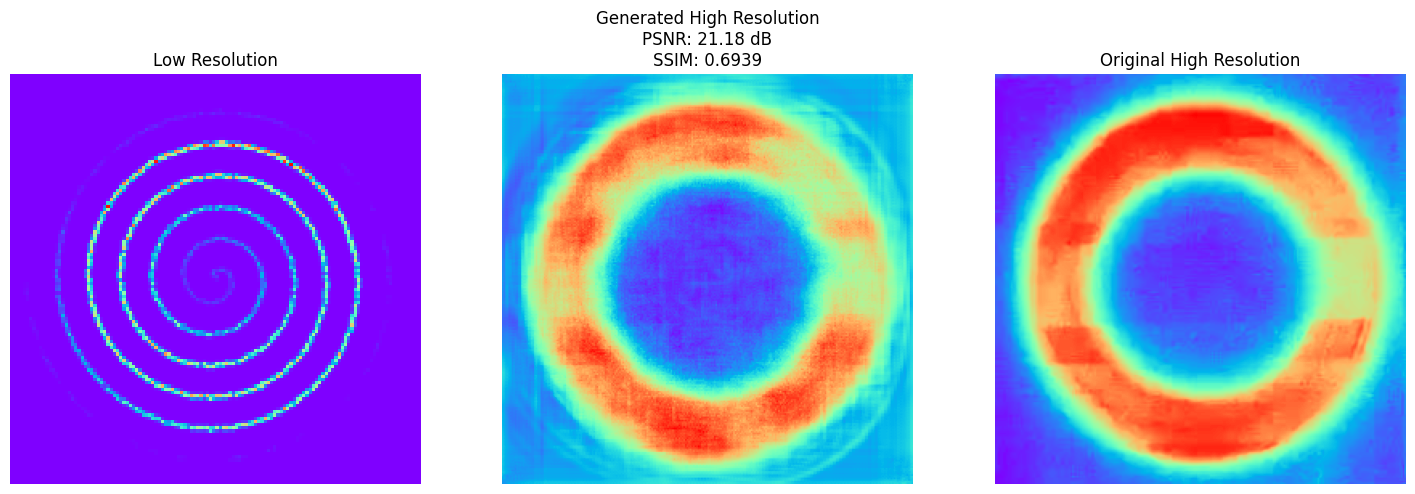

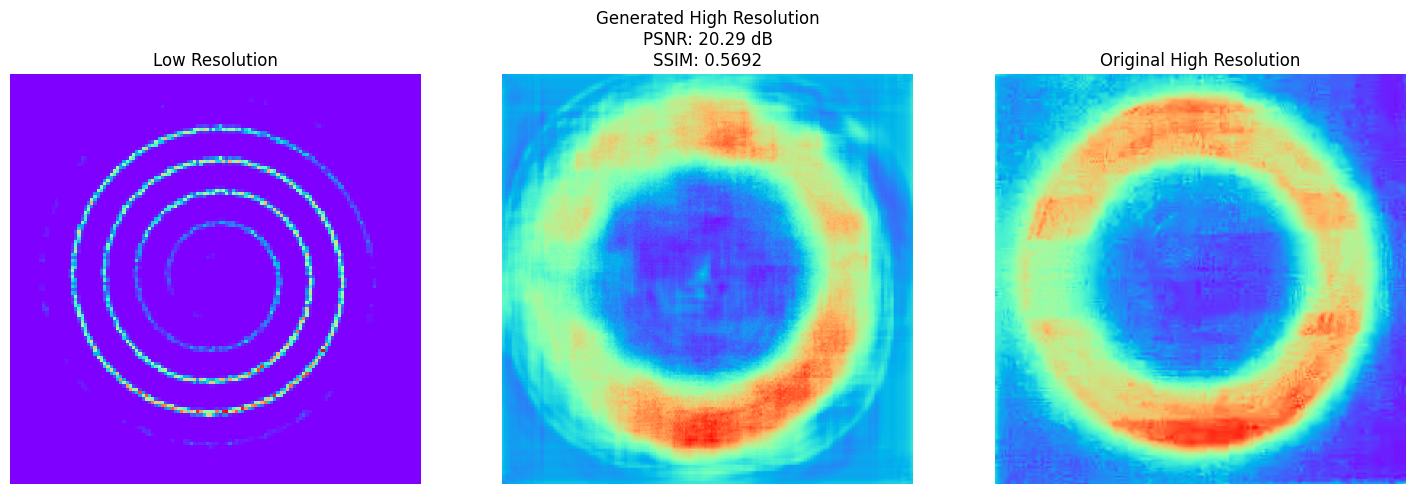

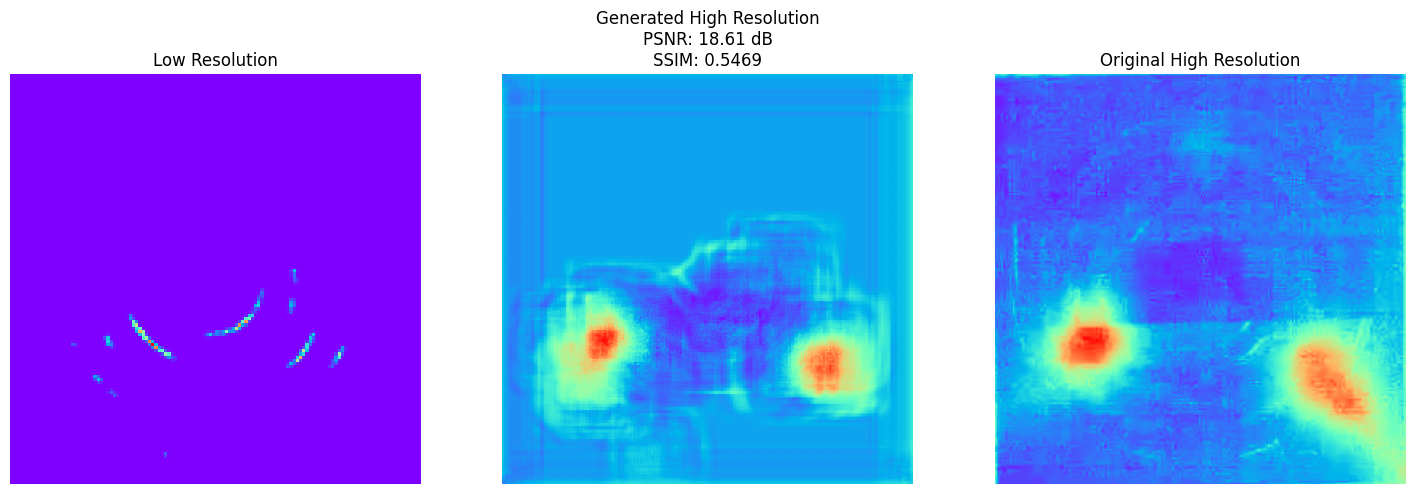

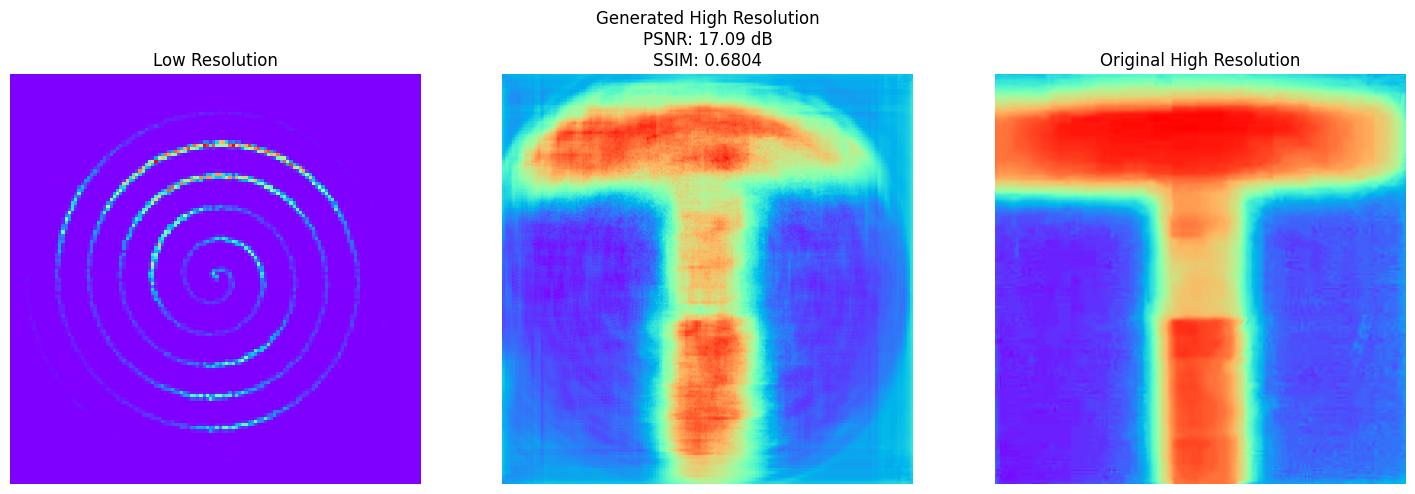

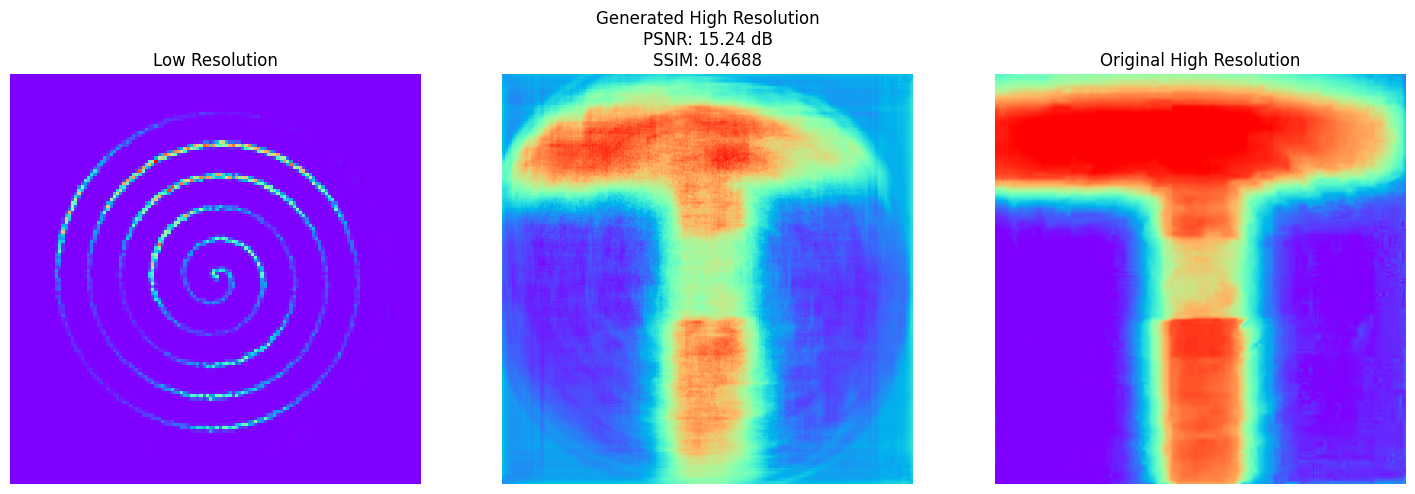

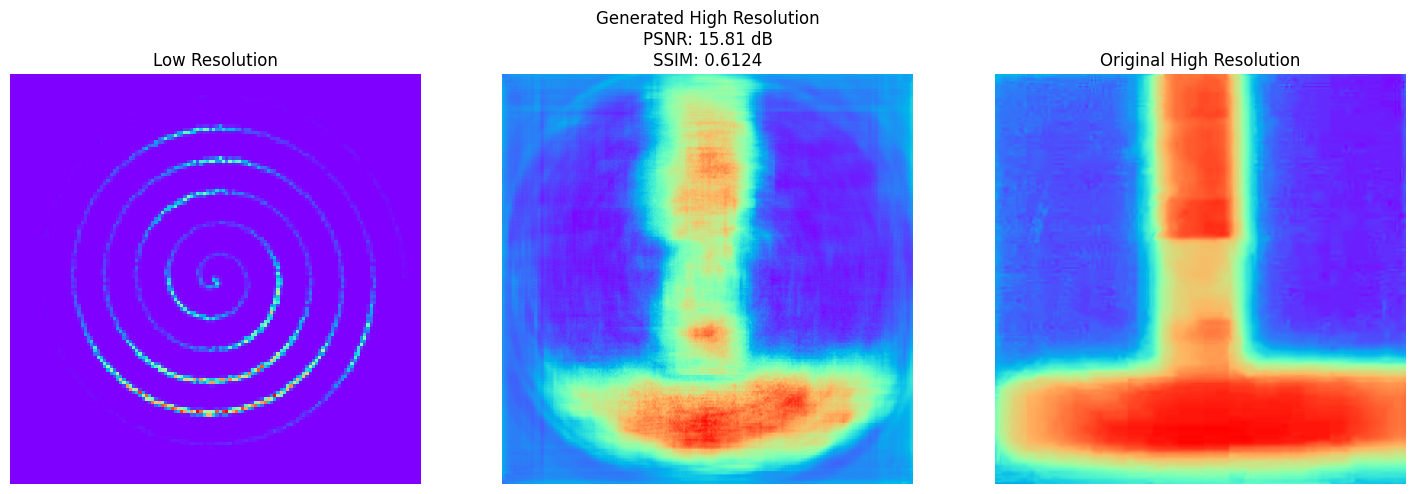

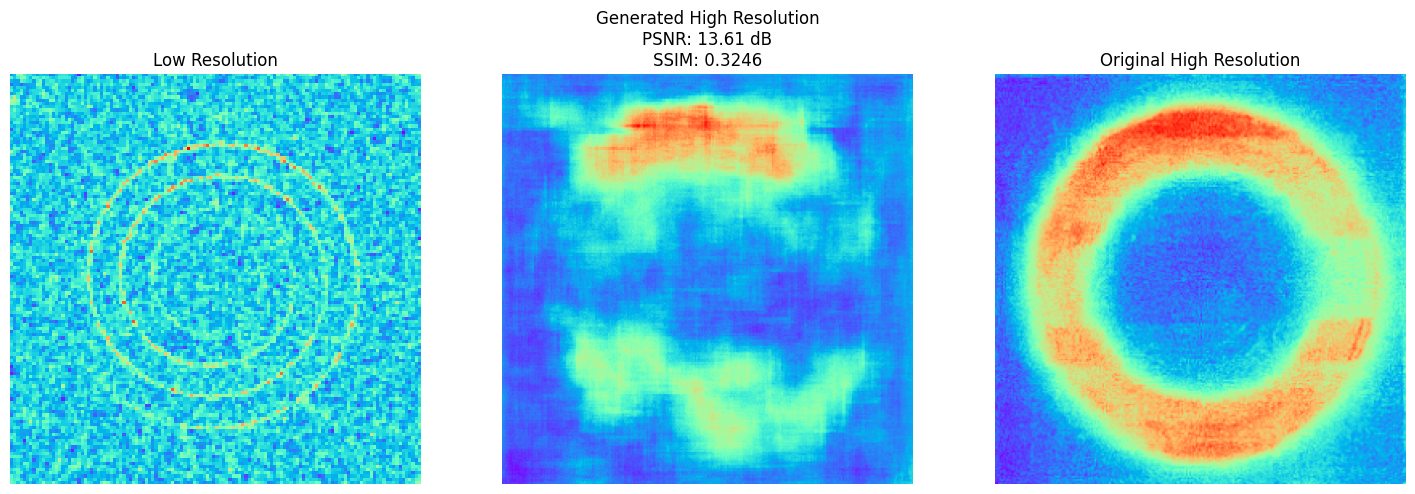

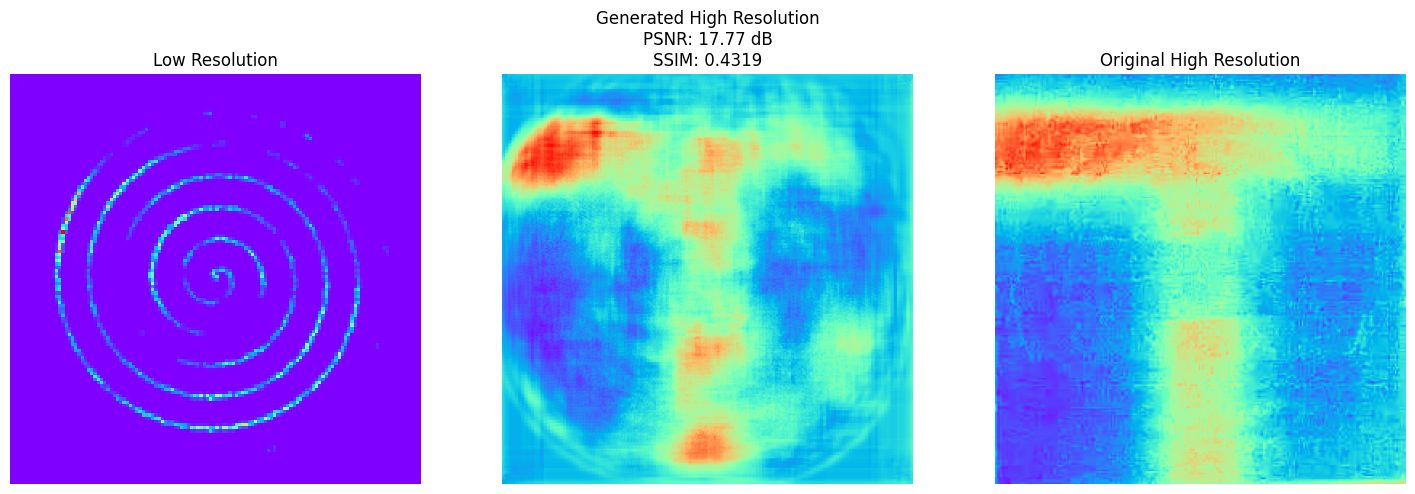

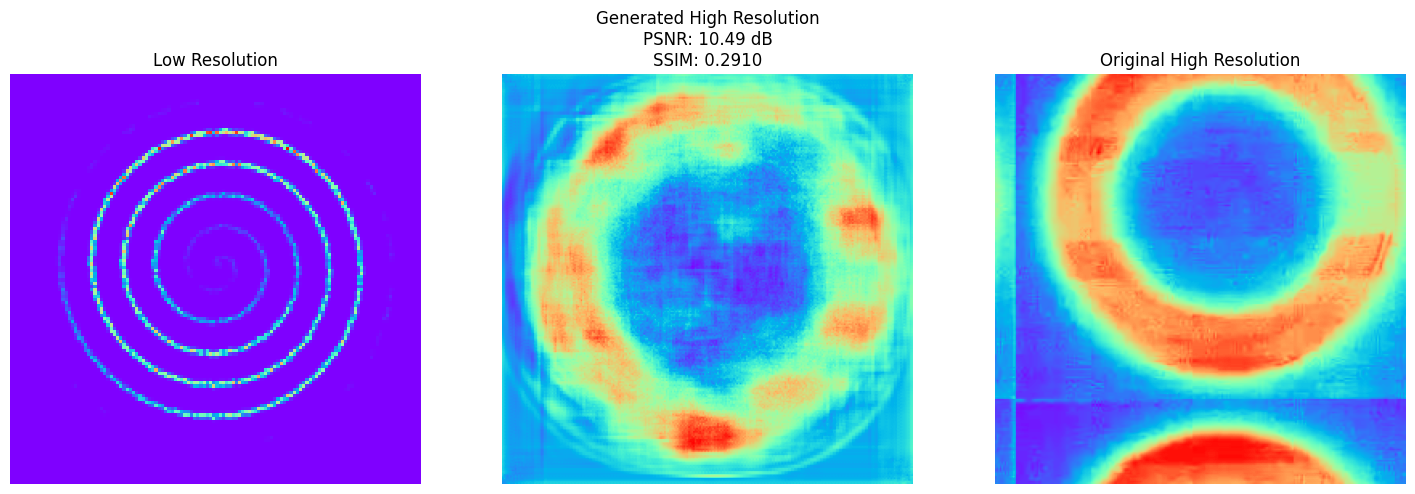

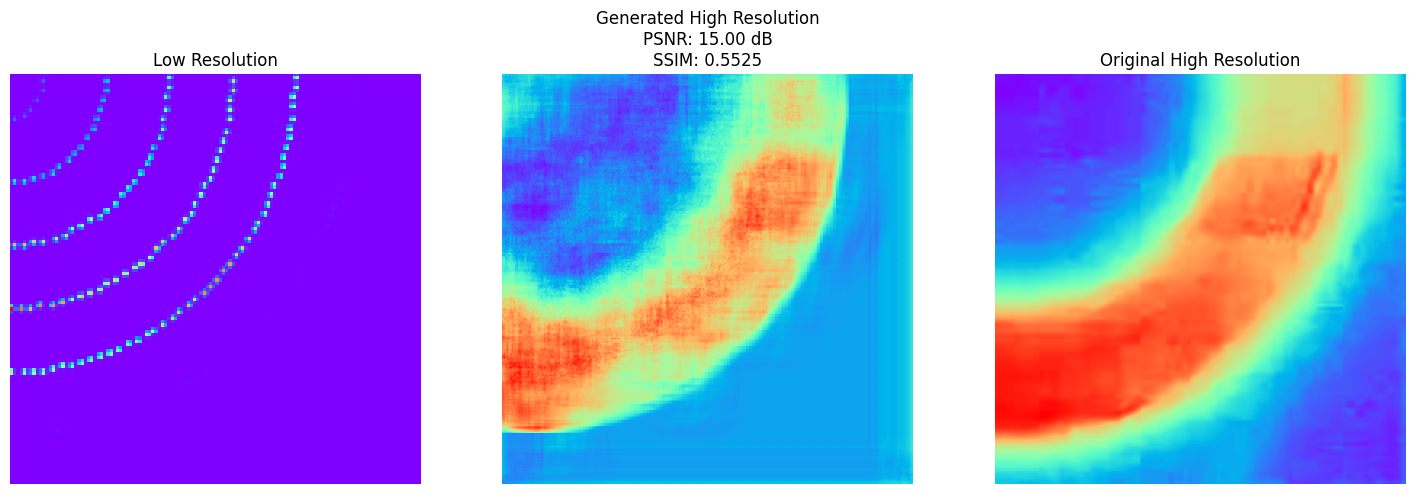

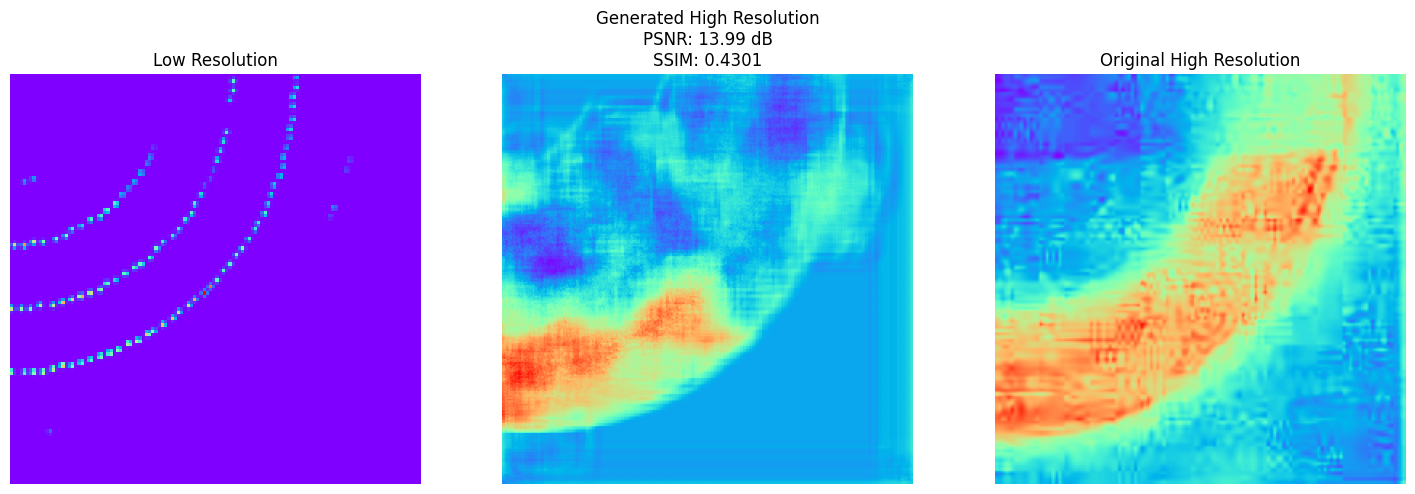

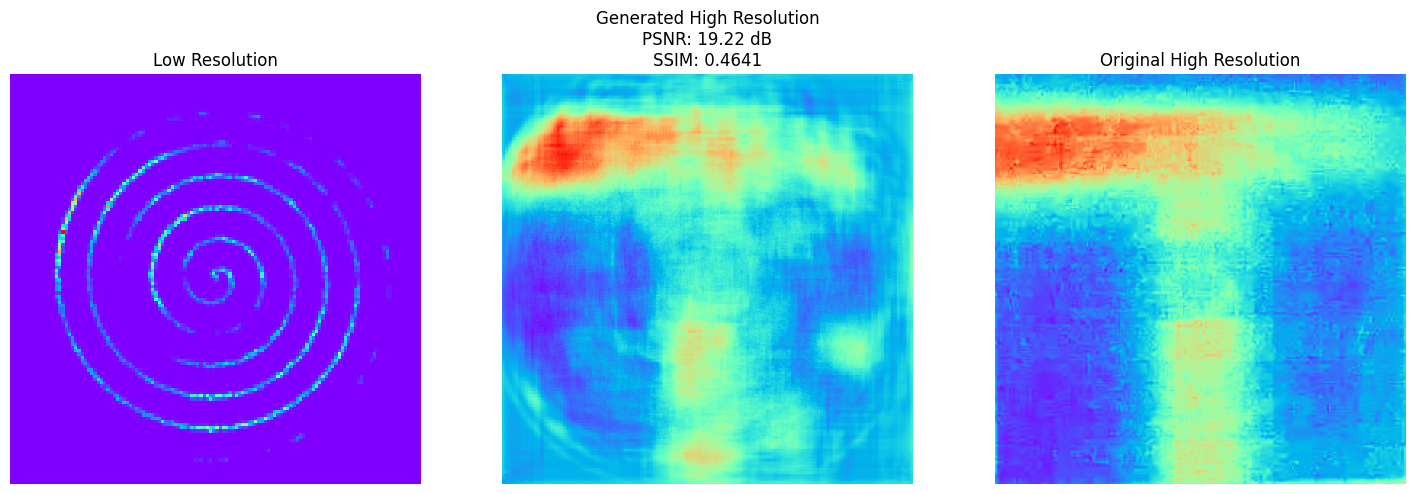

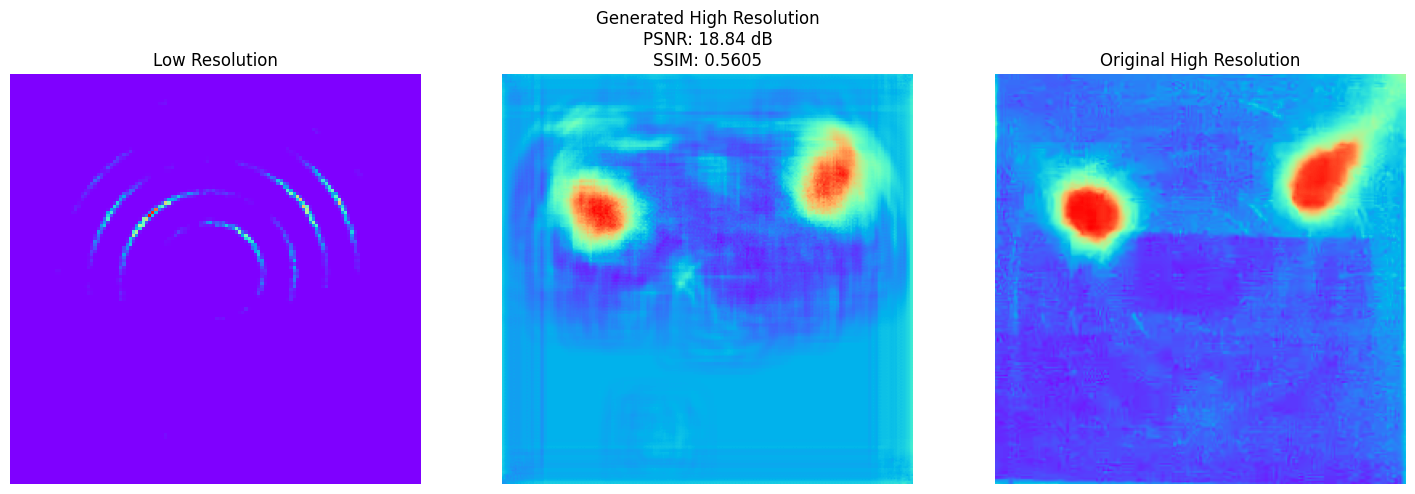

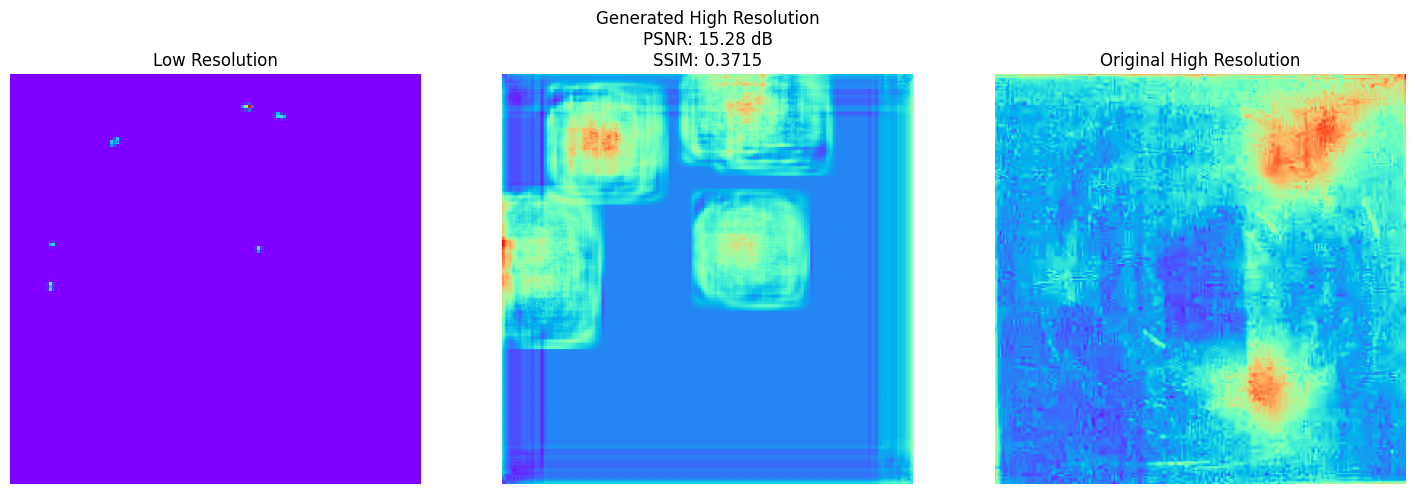

=== 整体指标 ===
平均 PSNR: 16.60 dB
平均 SSIM: 0.4998
平均 MAE: 0.1199
平均 MSE: 0.0273

=== 边界区域指标 ===
平均 PSNR (边界): 16.06 dB
平均 SSIM (边界): 0.5573
平均 MAE (边界): 0.1271
平均 MSE (边界): 0.0293

=== 中心区域指标 ===
平均 PSNR (中心): 18.45 dB
平均 SSIM (中心): 0.5716
平均 MAE (中心): 0.1076
平均 MSE (中心): 0.0239


In [4]:
# 加载最优模型及必要的库
import matplotlib.pyplot as plt
import torch
from skimage.metrics import peak_signal_noise_ratio as calculate_psnr
from skimage.metrics import structural_similarity as calculate_ssim
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import numpy as np


# 假设 'generator' 已经定义并且是 SRGAN 的生成器
generator.load_state_dict(torch.load('best_generator_srgan128.pth'))
generator.to(device)
generator.eval()

# 初始化指标累积变量
total_psnr = 0.0
total_ssim = 0.0
total_mae = 0.0
total_mse = 0.0
num_images = 0

# 初始化区域指标累积变量（例如边界区域和中心区域）
total_psnr_boundary = 0.0
total_ssim_boundary = 0.0
total_mae_boundary = 0.0
total_mse_boundary = 0.0

total_psnr_center = 0.0
total_ssim_center = 0.0
total_mae_center = 0.0
total_mse_center = 0.0

# 设置是否限制显示图像数量或保存图像
max_display = 14  # 例如，仅显示前14张图像
display_count = 0
save_images = False  # 如果希望保存图像，设置为True
output_dir = 'output_images'
if save_images:
    os.makedirs(output_dir, exist_ok=True)

# 定义区域掩码（假设图像为单通道且大小已知，例如 256x256）
image_size = 256  # 请根据实际图像大小调整
boundary_width = 50  # 边界区域的宽度

# 创建边界和中心区域的掩码
boundary_mask = np.zeros((image_size, image_size), dtype=bool)
boundary_mask[:boundary_width, :] = True
boundary_mask[-boundary_width:, :] = True
boundary_mask[:, :boundary_width] = True
boundary_mask[:, -boundary_width:] = True

center_mask = ~boundary_mask

with torch.no_grad():
    for i, (lr_imgs, hr_imgs) in enumerate(test_loader):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
        fake_imgs = generator(lr_imgs)
        
        batch_size = lr_imgs.size(0)
        num_images += batch_size
        
        for j in range(batch_size):
            # 如果限制显示次数并且已达到最大值，跳过
            if display_count >= max_display and not save_images:
                break
            display_count += 1
            
            # 将张量从GPU转移到CPU，并转换为numpy数组
            lr_img = lr_imgs[j].cpu().squeeze().numpy()  # 假设单通道
            fake_img = fake_imgs[j].cpu().squeeze().numpy()
            hr_img = hr_imgs[j].cpu().squeeze().numpy()
            
            # 计算整体PSNR和SSIM
            psnr = calculate_psnr(hr_img, fake_img, data_range=hr_img.max() - hr_img.min())
            ssim = calculate_ssim(hr_img, fake_img, data_range=hr_img.max() - hr_img.min())
            mae = mean_absolute_error(hr_img, fake_img)
            mse = mean_squared_error(hr_img, fake_img)
            
            total_psnr += psnr
            total_ssim += ssim
            total_mae += mae
            total_mse += mse
            
            # 计算区域内的PSNR和SSIM
            psnr_boundary = calculate_psnr(hr_img[boundary_mask], fake_img[boundary_mask], data_range=hr_img.max() - hr_img.min())
            ssim_boundary = calculate_ssim(hr_img[boundary_mask], fake_img[boundary_mask], data_range=hr_img.max() - hr_img.min())
            mae_boundary = mean_absolute_error(hr_img[boundary_mask], fake_img[boundary_mask])
            mse_boundary = mean_squared_error(hr_img[boundary_mask], fake_img[boundary_mask])
            
            psnr_center = calculate_psnr(hr_img[center_mask], fake_img[center_mask], data_range=hr_img.max() - hr_img.min())
            ssim_center = calculate_ssim(hr_img[center_mask], fake_img[center_mask], data_range=hr_img.max() - hr_img.min())
            mae_center = mean_absolute_error(hr_img[center_mask], fake_img[center_mask])
            mse_center = mean_squared_error(hr_img[center_mask], fake_img[center_mask])
            
            total_psnr_boundary += psnr_boundary
            total_ssim_boundary += ssim_boundary
            total_mae_boundary += mae_boundary
            total_mse_boundary += mse_boundary
            
            total_psnr_center += psnr_center
            total_ssim_center += ssim_center
            total_mae_center += mae_center
            total_mse_center += mse_center
            
            if not save_images:
                # 绘制图像
                plt.figure(figsize=(18, 6))
                
                # 低分辨率图像
                plt.subplot(1, 3, 1)
                plt.imshow(lr_img, cmap='rainbow')
                plt.title("Low Resolution")
                plt.axis('off')
                
                # 生成的高分辨率图像
                plt.subplot(1, 3, 2)
                plt.imshow(fake_img, cmap='rainbow')
                plt.title(f"Generated High Resolution\nPSNR: {psnr:.2f} dB\nSSIM: {ssim:.4f}")
                plt.axis('off')
                
                # 原始高分辨率图像
                plt.subplot(1, 3, 3)
                plt.imshow(hr_img, cmap='rainbow')
                plt.title("Original High Resolution")
                plt.axis('off')
                
                plt.show()
            else:
                # 绘制并保存图像
                plt.figure(figsize=(18, 6))
                
                # 低分辨率图像
                plt.subplot(1, 3, 1)
                plt.imshow(lr_img, cmap='coolwarm')
                plt.title("Low Resolution")
                plt.axis('off')
                
                # 生成的高分辨率图像
                plt.subplot(1, 3, 2)
                plt.imshow(fake_img, cmap='coolwarm')
                plt.title(f"Generated High Resolution\nPSNR: {psnr:.2f} dB\nSSIM: {ssim:.4f}")
                plt.axis('off')
                
                # 原始高分辨率图像
                plt.subplot(1, 3, 3)
                plt.imshow(hr_img, cmap='coolwarm')
                plt.title("Original High Resolution")
                plt.axis('off')
                
                # 保存图像
                plt.savefig(os.path.join(output_dir, f"test_{i}_{j}.png"), dpi=300)
                plt.close()
        
        # 如果限制显示次数并已达到最大值，跳出循环
        if display_count >= max_display and not save_images:
            break
num_images1 = 14 
# 计算并打印最终的平均指标
average_psnr = total_psnr / num_images1
average_ssim = total_ssim / num_images1
average_mae = total_mae / num_images1
average_mse = total_mse / num_images1

average_psnr_boundary = total_psnr_boundary / num_images1
average_ssim_boundary = total_ssim_boundary / num_images1
average_mae_boundary = total_mae_boundary / num_images1
average_mse_boundary = total_mse_boundary / num_images1

average_psnr_center = total_psnr_center / num_images1
average_ssim_center = total_ssim_center / num_images1
average_mae_center = total_mae_center / num_images1
average_mse_center = total_mse_center / num_images1

print("=== 整体指标 ===")
print(f"平均 PSNR: {average_psnr:.2f} dB")
print(f"平均 SSIM: {average_ssim:.4f}")
print(f"平均 MAE: {average_mae:.4f}")
print(f"平均 MSE: {average_mse:.4f}")

print("\n=== 边界区域指标 ===")
print(f"平均 PSNR (边界): {average_psnr_boundary:.2f} dB")
print(f"平均 SSIM (边界): {average_ssim_boundary:.4f}")
print(f"平均 MAE (边界): {average_mae_boundary:.4f}")
print(f"平均 MSE (边界): {average_mse_boundary:.4f}")

print("\n=== 中心区域指标 ===")
print(f"平均 PSNR (中心): {average_psnr_center:.2f} dB")
print(f"平均 SSIM (中心): {average_ssim_center:.4f}")
print(f"平均 MAE (中心): {average_mae_center:.4f}")
print(f"平均 MSE (中心): {average_mse_center:.4f}")

